# Combinatorial Optimization with Physics-Inspired Graph Neural Networks

In this notebook we show how to solve combinatorial optimization problems with physics-inspired graph neural networks, as outlined in M. J. A. Schuetz, J. K. Brubaker, H. G. Katzgraber, _Combinatorial Optimization with Physics-Inspired Graph Neural Networks_, [arXiv:2107.01188](https://arxiv.org/abs/2107.01188). 
Here we focus on the canonical maximum independent set (MIS) problem, but our approach can easily be extended to other combinatorial optimization problems. 
For the actual implementation of the graph neural network we use the open-source ```dgl``` library. 

Please note we have provided a `requirements.txt` file, which defines the environment required to run this code. Because some of the packages are not available on default OSX conda channels, we have also provided suggested channels to find them on. These can be distilled into a single line as such:

> conda create -n \<environment_name\> python=3 --file requirements.txt -c conda-forge -c dglteam -c pytorch

In [1]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation.clique import maximum_independent_set as mis
from time import time

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# DGL backend
os.environ['DGLBACKEND'] = 'pytorch'

Using backend: pytorch


In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


# Step 0 - Define utility functions

We first load a few general utility functions from ```utils.py``` before defining some helper functions specific to the MIS problem. 

### General utilities

In [3]:
from utils import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

### Problem-specific (MaxCut) utilities

In [4]:
def gen_q_dict_maxcut(nx_G):
    """Helper function to generate the QUBO matrix for MaxCUT bases on the adjacency matrix of the graph, following equation 7 of the paper

    Args:
        nx_G (networkx.Graph): A graph created with the networkx library

    Returns:
        dict: a dictionary where each item is a tuple representing an edge in the graph with a value given by the MaxCUT problem
    """
    Adj = nx.to_numpy_matrix(nx_G)
    #print(A)
    S = Adj.sum(axis=0)
    #print(S)
    Q_dic = defaultdict(int)
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = 2
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -S[0,u]

    return Q_dic

Test the maxcut Q matrix on a fixed graph instance in Fig. 2 of the paper. Note that the node labels start from 0 and are ordered.

In [5]:
test_graph = nx.OrderedGraph([(0,1),(0,2),(1,3),(2,3),(2,4),(3,4)])

/tmp/ipykernel_25607/2323816146.py:1: DeprecationWarning: OrderedGraph is deprecated and will be removed in version 3.0.
Use `Graph` instead, which guarantees order is preserved for
Python >= 3.7

  test_graph = nx.OrderedGraph([(0,1),(0,2),(1,3),(2,3),(2,4),(3,4)])


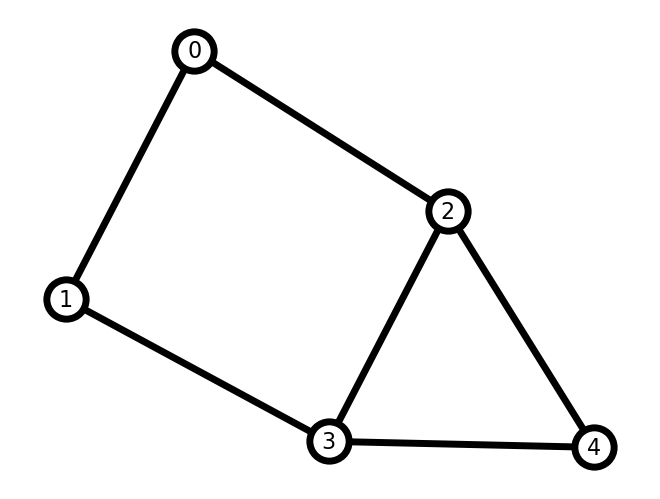

In [6]:
# Visualize graph
pos = nx.spring_layout(test_graph,seed=1)
options = {
    "font_size": 16,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw(test_graph, pos, with_labels=True, **options)

In [7]:
from matplotlib import pyplot as plt 

colors = ['r' for node in test_graph.nodes()]
pos = nx.spring_layout(test_graph, seed=1)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


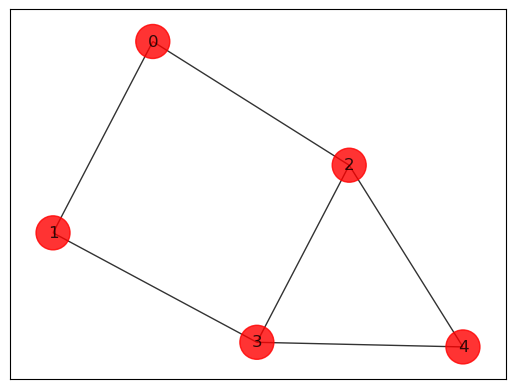

In [8]:
draw_graph(test_graph,colors,pos)

Adjecency matrix as in the Fig. 2 inset (a). 

In [9]:
adj = nx.to_numpy_matrix(test_graph)
print(adj)

[[0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 1.]
 [0. 1. 1. 0. 1.]
 [0. 0. 1. 1. 0.]]


Q matrix as in the Fig. 2 inset (a) for MaxCut

In [10]:
q_dict_maxcut = gen_q_dict_maxcut(test_graph)

In [11]:
qubo_dict_to_torch(test_graph,q_dict_maxcut)

tensor([[-2.,  2.,  2.,  0.,  0.],
        [ 0., -2.,  0.,  2.,  0.],
        [ 0.,  0., -3.,  2.,  2.],
        [ 0.,  0.,  0., -3.,  2.],
        [ 0.,  0.,  0.,  0., -2.]])

Test the MaxCut of this graph with 5 edges using a brute force approach that considers all possible $2^5$ combinations of 0,1 partitions

In [12]:
n = test_graph.number_of_nodes()

In [13]:
print(f"Number of nodes: {n}")
print(f"Combinations to try: {2**n}")

Number of nodes: 5
Combinations to try: 32


case = [0, 0, 0, 0, 0] cut = 0.0
case = [1, 0, 0, 0, 0] cut = 2.0
case = [0, 1, 0, 0, 0] cut = 2.0
case = [1, 1, 0, 0, 0] cut = 2.0
case = [0, 0, 1, 0, 0] cut = 3.0
case = [1, 0, 1, 0, 0] cut = 3.0
case = [0, 1, 1, 0, 0] cut = 5.0
case = [1, 1, 1, 0, 0] cut = 3.0
case = [0, 0, 0, 1, 0] cut = 3.0
case = [1, 0, 0, 1, 0] cut = 5.0
case = [0, 1, 0, 1, 0] cut = 3.0
case = [1, 1, 0, 1, 0] cut = 3.0
case = [0, 0, 1, 1, 0] cut = 4.0
case = [1, 0, 1, 1, 0] cut = 4.0
case = [0, 1, 1, 1, 0] cut = 4.0
case = [1, 1, 1, 1, 0] cut = 2.0
case = [0, 0, 0, 0, 1] cut = 2.0
case = [1, 0, 0, 0, 1] cut = 4.0
case = [0, 1, 0, 0, 1] cut = 4.0
case = [1, 1, 0, 0, 1] cut = 4.0
case = [0, 0, 1, 0, 1] cut = 3.0
case = [1, 0, 1, 0, 1] cut = 3.0
case = [0, 1, 1, 0, 1] cut = 5.0
case = [1, 1, 1, 0, 1] cut = 3.0
case = [0, 0, 0, 1, 1] cut = 3.0
case = [1, 0, 0, 1, 1] cut = 5.0
case = [0, 1, 0, 1, 1] cut = 3.0
case = [1, 1, 0, 1, 1] cut = 3.0
case = [0, 0, 1, 1, 1] cut = 2.0
case = [1, 0, 1, 1, 1] cut = 2.0
case = [0,

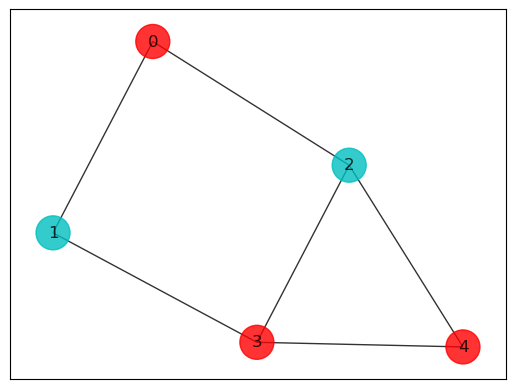

In [14]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + adj[i,j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print('case = ' + str(x)+ ' cut = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'c' for i in range(n)]
draw_graph(test_graph, colors, pos)
print('\nBest solution = ' + str(xbest_brute) + ' cut = ' + str(best_cost_brute))

The maximum cut value is 5, which corresponds to the number of edges with nodes of different colors. We should get the same result by evaluating the Hamiltonian of the corresponding Ising model with the spin configuration given by the coloring of the graph. We use the `loss_func` loss function for this, defined given a bitstring and a Q matrix

In [15]:
bitstring = torch.tensor(xbest_brute, dtype=TORCH_DTYPE)
q_mat = qubo_dict_to_torch(test_graph,q_dict_maxcut)

In [16]:
hamiltonian_maxcut = -loss_func(bitstring,q_mat)  # negative sign because of the minimization problem we run with the loss function
print(hamiltonian_maxcut)

tensor(5.)


Use the Goemans-Williamson (GW) algorithm to solve the problem. For this we use the `cvxgraphalgs` package

In [20]:
import cvxgraphalgs as cvxgr

In [29]:
gw_cut = cvxgr.algorithms.goemans_williamson_weighted(test_graph)


/home/enrico/miniconda3/envs/dgl38/lib/python3.8/site-packages/cvxgraphalgs/algorithms/max_cut.py:64: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.linalg.adjacency_matrix(graph)


In [33]:
def color_cut(graph, cut):
    colors = []
    for vertex in graph.nodes:
        color = 'c' if vertex in cut.left else 'r'
        colors.append(color)
    return colors

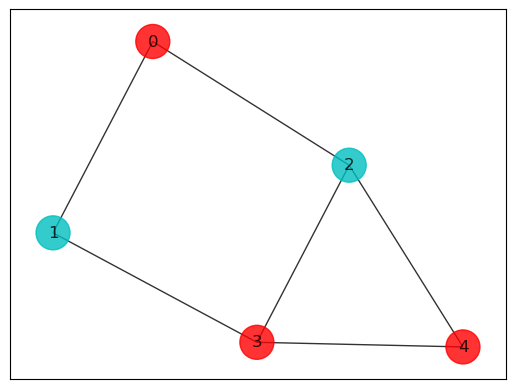

In [34]:
colors = color_cut(test_graph,gw_cut)
draw_graph(test_graph, colors, pos)

In [32]:
print('Cut size:', gw_cut.evaluate_cut_size(test_graph))

Cut size: 5


The result above may come out wrong...while the one below is correct

Cut size: 5


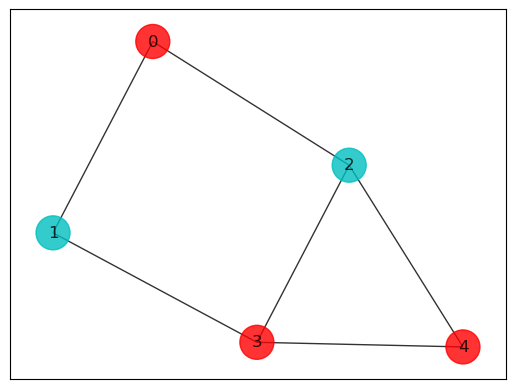

In [35]:
greedy_cut = cvxgr.algorithms.greedy_max_cut(test_graph)
colors = color_cut(test_graph, greedy_cut)
draw_graph(test_graph, colors, pos)
print('Cut size:', greedy_cut.evaluate_cut_size(test_graph))

In [59]:
from networkx.algorithms.approximation.maxcut import one_exchange

# Run classical greedy MAXCUT solver (provided by NetworkX)
def run_maxcut_solver(nx_graph, seed = 0):
    """
    Helper function to run traditional greedy solver for MaxCUT.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    random_state = np.random.RandomState(seed)
    # compare with traditional solver
    t_start = time()
    cut_value, partition = one_exchange(nx_graph, seed=random_state)
    t_solve = time() - t_start
    set_size_1 = len(partition[0])
    set_size_2 = len(partition[1])

    # get bitstring list
    # get bitstring list
    nx_bitstring = [1 if (node in partition[0]) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    return nx_bitstring, set_size_1, set_size_2, t_solve, partition, cut_value

Test it

In [60]:
nx_bitstring, set_size_1, set_size_2, t_solve, partition, cut_value = run_maxcut_solver(test_graph, 1)

In [61]:
print(f"The mxcut value is {cut_value}")

The mxcut value is 5


### Load G14 instance of GSet dataset

We have saved on disk the edge list of the G14 instance of the GSet dataset that can be found [here](https://web.stanford.edu/~yyye/yyye/Gset/). 
We read the edge list from disk and create the corresponding graph

In [36]:
g14 = np.loadtxt("g14.txt",dtype=int,skiprows=1,usecols=[0,1])

In [37]:
g14_edgelist = list(map(tuple, g14))
nx_temp = nx.from_edgelist(g14_edgelist, create_using=nx.OrderedGraph)
nx_temp = nx.relabel.convert_node_labels_to_integers(nx_temp)  # start labeling nodes from zero
# create ordered graph
g14_graph = nx.OrderedGraph()
g14_graph.add_nodes_from(sorted(nx_temp.nodes()))
g14_graph.add_edges_from(nx_temp.edges)

/tmp/ipykernel_5436/2033595618.py:5: DeprecationWarning: OrderedGraph is deprecated and will be removed in version 3.0.
Use `Graph` instead, which guarantees order is preserved for
Python >= 3.7

  g14_graph = nx.OrderedGraph()


In [39]:
# colors = ['r' for node in g14_graph.nodes()]
# pos = nx.spring_layout(g14_graph, seed=1)
# draw_graph(g14_graph, colors, pos)

Compute the MaxCUT with different algorithms

* GW (very slow: 4 minutes per instance)

In [ ]:
from cvxgraphalgs.structures import Cut 
best_cut = 0
best_config = Cut(nx.empty_graph(),nx.empty_graph())
for _ in range(100):
    gw_cut = cvxgr.algorithms.goemans_williamson_weighted(g14_graph)
    value_cut = gw_cut.evaluate_cut_size(g14_graph)
    if value_cut > best_cut:
        best_cut = value_cut
        best_config = gw_cut


* Greedy (fast, but not accurate)

In [50]:
from cvxgraphalgs.structures import Cut 
best_cut = 0
best_config = Cut(nx.empty_graph(),nx.empty_graph())
for _ in range(500):
    greedy_cut = cvxgr.algorithms.greedy_max_cut(g14_graph)
    value_cut = greedy_cut.evaluate_cut_size(g14_graph)
    if value_cut > best_cut:
        best_cut = value_cut
        best_config = greedy_cut

In [51]:
best_cut

2891

* One-exchange (slow: almost 4 minutes)

In [52]:
best_cut = 0
best_config = []
# for _ in range(500):
nx_bitstring, set_size_1, set_size_2, t_solve, partition, value_cut = run_maxcut_solver(g14_graph)
if value_cut > best_cut:
    best_cut = value_cut
    best_config = nx_bitstring

In [53]:
best_cut

2952

In [55]:
fixed_problem_run = lambda i: run_maxcut_solver(g14_graph, seed=i)

In [62]:
from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=10) as executor:
    results = executor.map(fixed_problem_run, np.arange(100))

In [72]:
[r for r in results]

[]

### Problem-specific (MIS) utilities

In [6]:
# helper function to generate Q matrix for Maximum Independent Set problem (MIS)
def gen_q_dict_mis(nx_G, penalty=2):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u, v) in nx_G.edges:
        Q_dic[(u, v)] = penalty

    # all diagonal terms get -1
    for u in nx_G.nodes:
        Q_dic[(u, u)] = -1

    return Q_dic


# Run classical MIS solver (provided by NetworkX)
def run_mis_solver(nx_graph):
    """
    helper function to run traditional solver for MIS.
    
    Input:
        nx_graph: networkx Graph object
    Output:
        ind_set_bitstring_nx: bitstring solution as list
        ind_set_nx_size: size of independent set (int)
        number_violations: number of violations of ind.set condition
    """
    # compare with traditional solver
    t_start = time()
    ind_set_nx = mis(nx_graph)
    t_solve = time() - t_start
    ind_set_nx_size = len(ind_set_nx)

    # get bitstring list
    nx_bitstring = [1 if (node in ind_set_nx) else 0 for node in sorted(list(nx_graph.nodes))]
    edge_set = set(list(nx_graph.edges))

    # Updated to be able to handle larger scale
    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set_nx, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return nx_bitstring, ind_set_nx_size, number_violations, t_solve


# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mis(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mis: Size of MIS (int)
        ind_set: MIS (list of integers)
        number_violations: number of violations of ind.set condition
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    # compute cost
    size_mis = sum(bitstring_list)

    # get independent set
    ind_set = set([node for node, entry in enumerate(bitstring_list) if entry == 1])
    edge_set = set(list(nx_graph.edges))

    print('Calculating violations...')
    # check for violations
    number_violations = 0
    for ind_set_chunk in gen_combinations(combinations(ind_set, 2), 100000):
        number_violations += len(set(ind_set_chunk).intersection(edge_set))

    return size_mis, ind_set, number_violations

# Step 1 - Set hyperparameters

In [17]:
# Graph hypers
n = 100
d = 3
p = None
graph_type = 'reg'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 1000    # number early stopping triggers before breaking loop

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
hidden_dim = int(dim_embedding/2)  # e.g. 5

# Step 2 - Generate random graph

In [20]:
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_maxcut(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating d-regular graph with n=100, d=3, seed=1


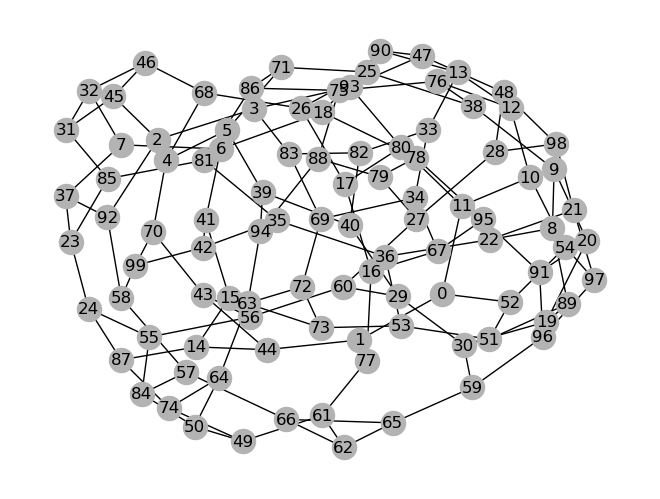

In [21]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

# Step 3 - Set up optimizer/GNN architecture

In [22]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [31]:
net

GCN_dev(
  (conv1): GraphConv(in=10, out=5, normalization=both, activation=None)
  (conv2): GraphConv(in=5, out=1, normalization=both, activation=None)
)

# Step 4 - Run GNN training

In [23]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: -2.4419946670532227
Epoch: 1000, Loss: -22.92064094543457
Epoch: 2000, Loss: -71.82173919677734
Epoch: 3000, Loss: -104.43206787109375
Epoch: 4000, Loss: -118.85728454589844
Epoch: 5000, Loss: -125.68896484375
Epoch: 6000, Loss: -128.7184600830078
Epoch: 7000, Loss: -129.91592407226562
Epoch: 8000, Loss: -130.4512176513672
Epoch: 9000, Loss: -130.71182250976562
Epoch: 10000, Loss: -130.84519958496094
Epoch: 11000, Loss: -130.91534423828125
Stopping early on epoch 11597 (patience: 1000)
GNN training (n=100) took 21.212
GNN final continuous loss: -130.94061279296875
GNN best continuous loss: -130.94061279296875


# Step 5 - Post-process GNN results

In [30]:
hamiltonian_maxcut = -loss_func(best_bitstring,q_torch.type(torch.LongTensor))
print(hamiltonian_maxcut.detach().numpy())

131


In [21]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring.detach().numpy()])

# Process bitstring reported by GNN
size_mis, ind_set, number_violations = postprocess_gnn_mis(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'Independence number found by GNN is {size_mis} with {number_violations} violations')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

Calculating violations...
Independence number found by GNN is 41 with 0 violations
Took 217.183s, model training took 25.503s


In [22]:
final_bitstring_str

'1,0,0,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0'

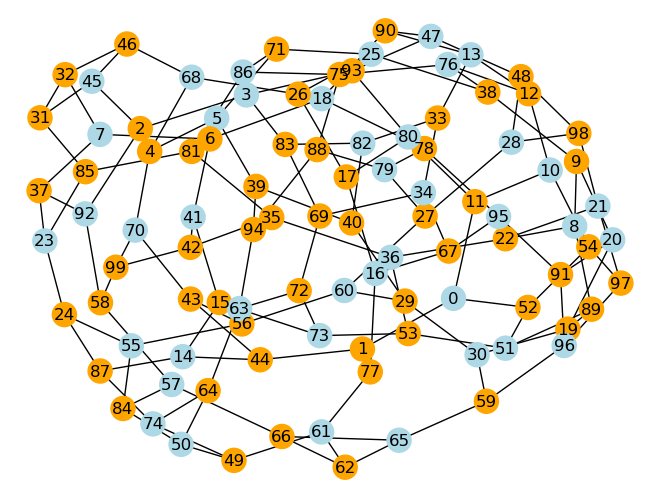

In [23]:
# Visualize result
# Note no light-blue nodes are connected by an edge
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)

# Step 6 - (optional) Compare to classical solver

In [29]:
# run solver
print(f'Running built-in MIS solver (n={n}).')
start = time()
ind_set_bitstring_nx, ind_set_nx_size, nx_number_violations, t_solve = run_mis_solver(nx_graph)
end = time()
runtime_sol = end - start
print(f'Independence number found by nx solver is {ind_set_nx_size} with {nx_number_violations} violations.')
print(f'MIS solver took {round(runtime_sol, 3)}s')

Running built-in MIS solver (n=100).
Calculating violations...
Independence number found by nx solver is 36 with 0 violations.
MIS solver took 0.329s
